In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import rescomp as rc
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10]

# Hyperparameter Combinations

### Functions

In [2]:
def L2(x, axis=0):
    return np.sum(x**2, axis=axis)**0.5
def Linf(x, axis=0):
    return np.max(np.abs(x), axis=axis)

def relerr(true, pre, order=2, axis=0):
    if order == 2:
        norm = L2
    if order == "inf":
        norm = Linf
    return norm(true - pre, axis=axis) / norm(true, axis=axis)

def accduration(true, pre, tol=0.2, order="inf", axis=0):
    n = pre.shape[axis]
    for i in range(n):
        if axis == 0:
            t = true[i, :]
            p = pre[i, :]
        if axis == 1:
            t = true[:, i]
            p = pre[:, i]
        if relerr(t, p, order=order, axis=0) > tol:
            return i
    return n - 1

def system_fit_error(t, pre, system, order=2):
    df = rc.SYSTEMS[system]["df"]
    trueprime = df(t, pre)
    dt = np.mean(np.diff(t))
    fdprime = np.gradient(pre, dt, axis=1)
    err = relerr(trueprime, fdprime)
    if order == 2:
        return np.mean(err)
    if order == inf:
        return np.max(err)
    return err

def train_test_orbit(system, duration=10, dt=0.01, trainper=0.5):
    t, U = rc.orbit(system, duration=duration, dt=dt, trim=True)
        # Train and test data
    N = len(t)
    mid = int(N * trainper)
    tr, Utr = t[:mid], U[:mid, :]
    ts, Uts = t[mid:], U[mid:, :]
    return tr, Utr, ts, Uts

def topprms(sherpafile, acctol):
    prmdf = pd.read_csv(sherpafile)
    trials = prmdf.groupby("Trial-ID").agg(["mean", "std"])
    mask = trials["Objective"]["mean"] > acctol
    print(trials["Objective"][mask])
    return prmdf

def compareorbits(t, true, pre, tol=0.2):
    c = np.random.rand(3)
    plt.plot(t, pre, c=c)
    plt.plot(t, true, c="gray")
    # Plot divergence in orbits
    n = len(t)
    y = np.linspace(np.min(pre), np.max(pre), n)
    failidx = accduration(true, pre, tol=tol, order=2)
    one = np.ones(n)
    plt.plot(t[failidx] * one, y, c="r", label="Divergence")
    plt.plot(t[0], pre[0, 0], c=c, label="Prediction")
    plt.plot(t[0], true[0, 0], c="gray", label="True")
    plt.legend()
    plt.title("Orbit Comparison")
    plt.show()
    return c

## Rossler

In [3]:
rosslerfile = "/Users/djpassey/Data/RCAlgorithm/Hyperparameter/rossler/"
data = "results.csv"
config = "config.pkl"

In [4]:
rosslerdf = topprms(rosslerfile + data, 6.0)

              mean       std
Trial-ID                    
7         9.685238  5.166389
92        9.479048  4.640226
110       7.489048  5.128295
112       7.632381  4.885597
118       7.018095  6.587142
167       6.541429  5.054439
177       6.692381  5.441824
189       7.921429  4.642044


In [5]:
mask = rosslerdf["Trial-ID"] == 92
rosslerdf[mask]

,Trial-ID,Status,Iteration,gamma,mean_degree,ridge_alpha,sigma,spect_rad,Objective
1911,92,INTERMEDIATE,0,5.632587,0.210108,2.011735e-07,0.07792,14.617091,1.41
1912,92,INTERMEDIATE,1,5.632587,0.210108,2.011735e-07,0.07792,14.617091,4.99
1913,92,INTERMEDIATE,2,5.632587,0.210108,2.011735e-07,0.07792,14.617091,13.43
1914,92,INTERMEDIATE,3,5.632587,0.210108,2.011735e-07,0.07792,14.617091,15.00
1915,92,INTERMEDIATE,4,5.632587,0.210108,2.011735e-07,0.07792,14.617091,15.00
1916,92,INTERMEDIATE,5,5.632587,0.210108,2.011735e-07,0.07792,14.617091,9.27
1917,92,INTERMEDIATE,6,5.632587,0.210108,2.011735e-07,0.07792,14.617091,8.67
1918,92,INTERMEDIATE,7,5.632587,0.210108,2.011735e-07,0.07792,14.617091,1.87
1919,92,INTERMEDIATE,8,5.632587,0.210108,2.011735e-07,0.07792,14.617091,2.27
1920,92,INTERMEDIATE,9,5.632587,0.210108,2.011735e-07,0.07792,14.617091,12.44


In [6]:
ROSSLERPRMS = {
    "res_sz" : 1000,
    "activ_f" : lambda x: 1 / (1 + np.exp(-1*x)),
    "gamma" : 5.632587,
    "mean_degree" : 0.21,
    "ridge_alpha" : 2e-7,
    "sigma" : 0.078,
    "spect_rad" : 14.6
}

## Old Algorithm: Save internal state

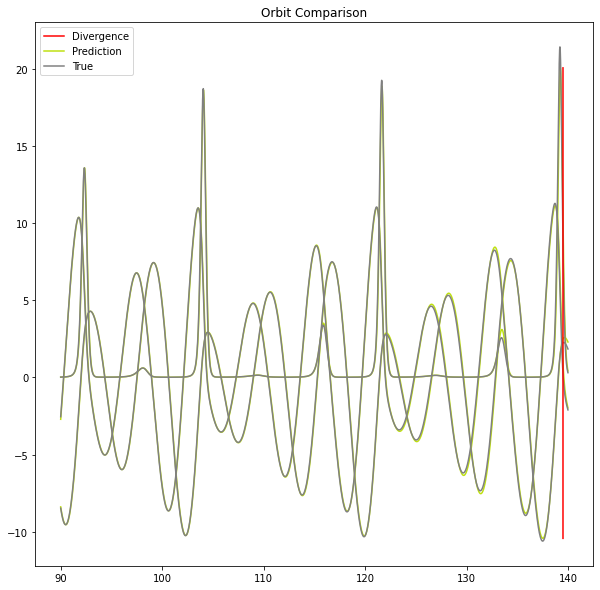

In [7]:
tr, Utr, ts, Uts = train_test_orbit("rossler", duration=100)
rcomp = rc.ResComp(**ROSSLERPRMS)
rcomp.train(tr, Utr)
r0 = rcomp.r0
pre = rcomp.predict(ts, r0=r0)
col = compareorbits(ts, Uts, pre)

## Old Algorithm (Unseen Initial)

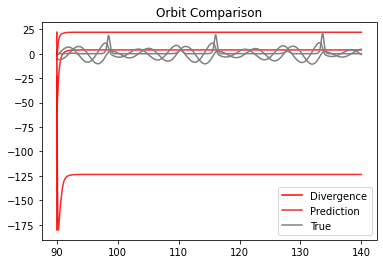

In [77]:
tr, Utr, ts, Uts = train_test_orbit("rossler", duration=100)
rcomp = rc.ResComp(**ROSSLERPRMS)
rcomp.train(tr, Utr)
u0 = Uts[0, :]
pre = rcomp.predict(ts, u0=u0)
col = compareorbits(ts, Uts, pre)

## New Algorithm (Unseen Initial)

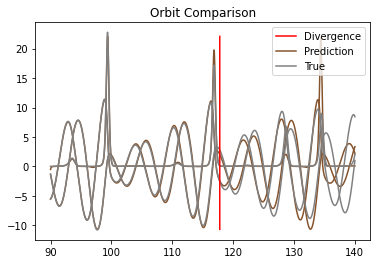

In [79]:
tr, Utr, ts, Uts = train_test_orbit("rossler", duration=100)
rcomp = rc.ResComp(**ROSSLERPRMS)
rcomp.train(tr, Utr, window=10, overlap=0.95)
u0 = Uts[0, :]
pre = rcomp.predict(ts, u0=u0)
col = compareorbits(ts, Uts, pre)

## Thomas

In [5]:
thomasfile = "/Users/djpassey/Data/RCAlgorithm/Hyperparameter/thomas/results.csv"
thomasdf = topprms(thomasfile, 70)

               mean         std
Trial-ID                       
26        71.576190  114.251967
120       72.166667  101.707804
157       95.400000  132.990624
167       81.014286  125.550700
186       86.885714  123.009525


In [6]:
mask = thomasdf["Trial-ID"] == 157
thomasdf[mask]

,Trial-ID,Status,Iteration,gamma,mean_degree,ridge_alpha,sigma,spect_rad,Objective
3276,157,INTERMEDIATE,0,12.606626,2.198742,0.000522,1.511143,11.925567,4.4
3277,157,INTERMEDIATE,1,12.606626,2.198742,0.000522,1.511143,11.925567,7.0
3278,157,INTERMEDIATE,2,12.606626,2.198742,0.000522,1.511143,11.925567,13.6
3279,157,INTERMEDIATE,3,12.606626,2.198742,0.000522,1.511143,11.925567,3.5
3280,157,INTERMEDIATE,4,12.606626,2.198742,0.000522,1.511143,11.925567,300.0
3281,157,INTERMEDIATE,5,12.606626,2.198742,0.000522,1.511143,11.925567,40.2
3282,157,INTERMEDIATE,6,12.606626,2.198742,0.000522,1.511143,11.925567,20.8
3283,157,INTERMEDIATE,7,12.606626,2.198742,0.000522,1.511143,11.925567,12.7
3284,157,INTERMEDIATE,8,12.606626,2.198742,0.000522,1.511143,11.925567,16.4
3285,157,INTERMEDIATE,9,12.606626,2.198742,0.000522,1.511143,11.925567,35.2


In [3]:
THOMASPRMS = {
    "res_sz" : 1000,
    "activ_f" : lambda x: 1/(1 + np.exp(-1*x)),
    "gamma" : 12.6,
    "mean_degree" : 2.2,
    "ridge_alpha" : 5e-4,
    "sigma" : 1.5,
    "spect_rad" : 12.0
}

## Old Method (Maintain internal state)

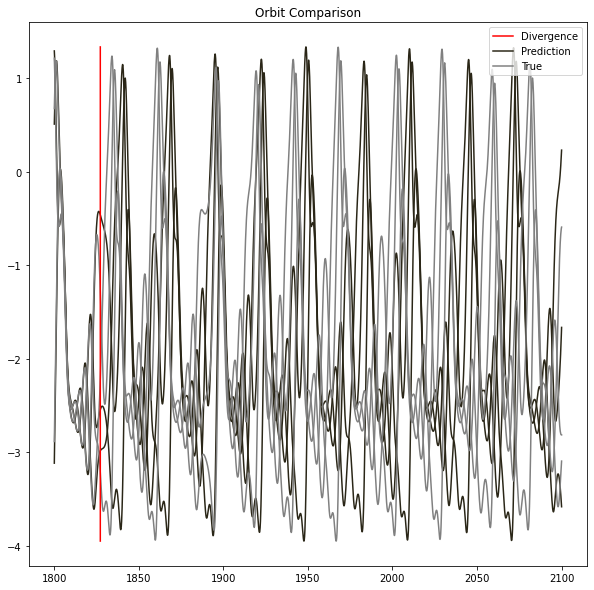

In [24]:
tr, Utr, ts, Uts = train_test_orbit("thomas", duration=2000, dt=0.1, trainper=0.85)
rcomp = rc.ResComp(**THOMASPRMS)
rcomp.train(tr, Utr)
pre = rcomp.predict(ts, r0=rcomp.r0)
col = compareorbits(ts, Uts, pre, tol=0.3)

In [32]:
system_fit_error(ts, pre, "lorenz")

23.66982457943725

In [34]:
system_fit_error(ts, Uts, "lorenz")

24.111164096229334

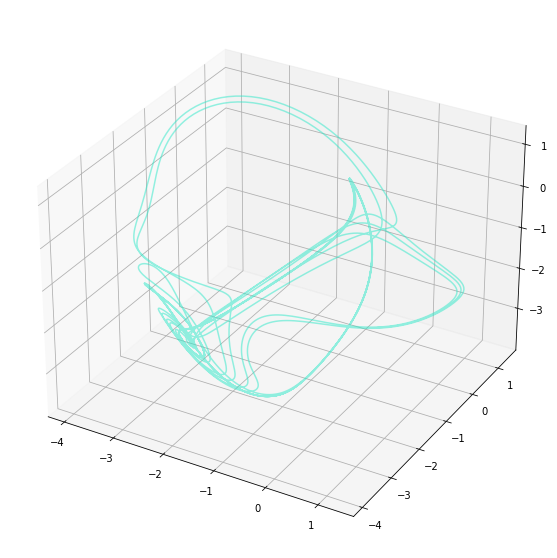

In [16]:
col = rc.plot3d(pre)

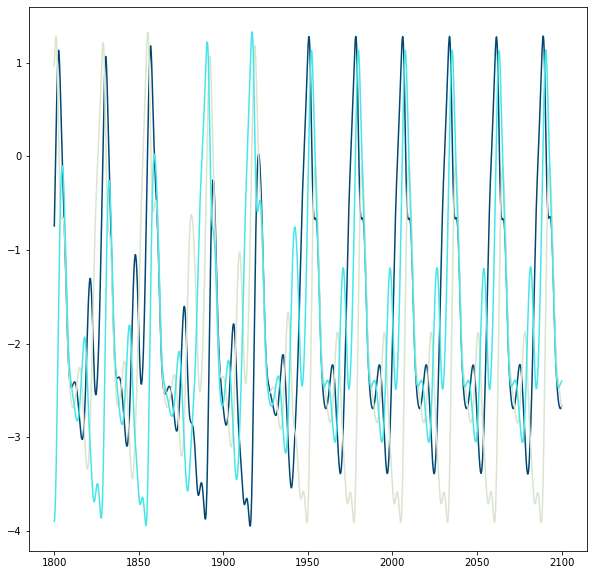

array([[0.00484768, 0.27675273, 0.44856433],
       [0.8560401 , 0.89894435, 0.81109911],
       [0.27137193, 0.90218404, 0.90994906]])

In [15]:
rc.plot2d(ts, pre)

## Lorenz

In [7]:
lorenzfile = "/Users/djpassey/Data/RCAlgorithm/Hyperparameter/lorenz/results.csv"
lorenzdf = topprms(lorenzfile, 3)

              mean       std
Trial-ID                    
15        3.549048  2.037484
146       3.612381  1.956019
148       3.069524  1.866292
168       4.998571  2.302942
195       6.673333  4.820810


In [8]:
mask = lorenzdf["Trial-ID"] == 168
lorenzdf[mask]

,Trial-ID,Status,Iteration,gamma,mean_degree,ridge_alpha,sigma,spect_rad,Objective
3507,168,INTERMEDIATE,0,19.094498,1.964573,6.095018e-07,0.062527,8.471979,4.57
3508,168,INTERMEDIATE,1,19.094498,1.964573,6.095018e-07,0.062527,8.471979,6.01
3509,168,INTERMEDIATE,2,19.094498,1.964573,6.095018e-07,0.062527,8.471979,3.83
3510,168,INTERMEDIATE,3,19.094498,1.964573,6.095018e-07,0.062527,8.471979,7.75
3511,168,INTERMEDIATE,4,19.094498,1.964573,6.095018e-07,0.062527,8.471979,6.27
3512,168,INTERMEDIATE,5,19.094498,1.964573,6.095018e-07,0.062527,8.471979,8.15
3513,168,INTERMEDIATE,6,19.094498,1.964573,6.095018e-07,0.062527,8.471979,0.17
3514,168,INTERMEDIATE,7,19.094498,1.964573,6.095018e-07,0.062527,8.471979,1.68
3515,168,INTERMEDIATE,8,19.094498,1.964573,6.095018e-07,0.062527,8.471979,7.31
3516,168,INTERMEDIATE,9,19.094498,1.964573,6.095018e-07,0.062527,8.471979,4.24


In [29]:
LORENZPRMS = {
    "res_sz" : 1000,
    "activ_f" : lambda x: 1/(1 + np.exp(-1*x)),
    "gamma" : 19.1,
    "mean_degree" : 2.0,
    "ridge_alpha" : 6e-7,
    "sigma" : 0.063,
    "spect_rad" : 8.472
}

## Old Method (Maintain internal state)

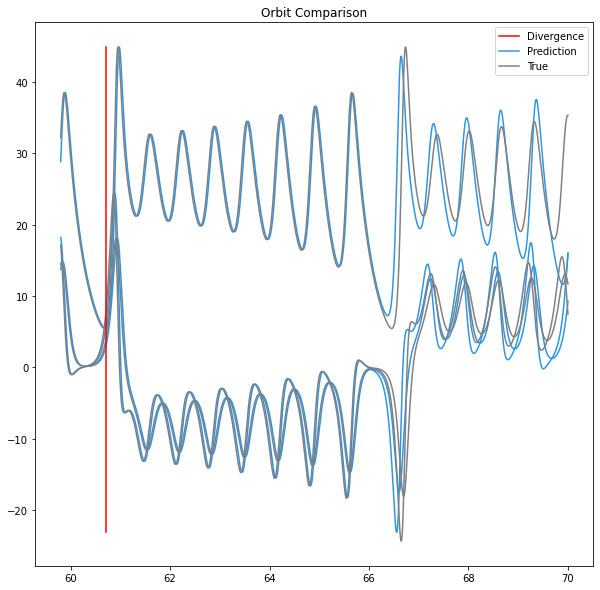

In [30]:
tr, Utr, ts, Uts = train_test_orbit("lorenz", duration=30, dt=0.01, trainper=0.66)
rcomp = rc.ResComp(**LORENZPRMS)
rcomp.train(tr, Utr)
pre = rcomp.predict(ts, r0=rcomp.r0)
col = compareorbits(ts, Uts, pre)